# Set an Environment

In [10]:
%cd drive/MyDrive/Projects/AFTER

/content/drive/MyDrive/Projects/AFTER


In [11]:
import copy
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Define DQS

In [3]:
def dqs(preds: pd.DataFrame, lamb: float) -> pd.Series:
  taus = getTaus(preds, lamb)
  return pd.Series(map(lambda t, q: preds.loc[t].quantile(q), preds.index, taus), index=preds.index)

In [4]:
def getTaus(preds: pd.DataFrame, lamb: float) -> pd.Series:
  return ((np.sign(preds.mean(axis=1).diff().dropna()) * preds.std(axis=1).diff().dropna().apply(lambda x: max(0, x)) * preds.var(axis=1) * lamb).apply(lambda x: min(max(x, -0.5), 0.5)) + 0.5).fillna(0.5)

In [5]:
def calculateMAE(y_true: pd.Series, y_pred: pd.Series) -> float:
  return mean_absolute_error(y_true, y_pred)

In [6]:
def calculateMAEforLambda(preds: pd.DataFrame, lamb: float, y_true: pd.Series) -> float:
  return calculateMAE(y_true, dqs(preds, lamb))

In [7]:
def removeOutlier(preds: pd.DataFrame) -> pd.Series:
  preds = copy.deepcopy(preds)
  for t in preds.index:
    lqr = preds.loc[t].quantile(0.75) - preds.loc[t].quantile(0.25)
    lowerBound = preds.loc[t].quantile(0.25) - 1.5 * lqr
    upperBound = preds.loc[t].quantile(0.25) + 1.5 * lqr
    for col in preds.columns:
      if not lowerBound <= preds.loc[t, col] <= upperBound:
        preds.loc[t, col] = np.nan
  return preds


# Current Quater

## Load Data

In [17]:
preds= pd.read_excel('pred_now.xlsx', index_col='TIME')
preds.index = pd.PeriodIndex(preds.index, freq='M')
preds = preds.asfreq('Q-DEC')

In [19]:
errors = pd.read_excel('error_now.xlsx', index_col='TIME')
errors.index = pd.PeriodIndex(errors.index, freq='M')
errors = errors.asfreq('Q-DEC')

In [20]:
true = pd.read_excel('GDP_true.xlsx', index_col='TIME')
true.index = pd.PeriodIndex(true.index, freq='M')
true = true.asfreq('Q-DEC')
true = true.reindex(errors.index)
true = true['GDP(SA)']

## Ensemble

In [21]:
lambs = np.linspace(0, 64, 641)
ensemble = pd.DataFrame(data={'DQS': map(lambda lamb: calculateMAEforLambda(preds=removeOutlier(preds), lamb=lamb, y_true=true), lambs)}, index=pd.Index(lambs, name='Lambda'))

In [22]:
ensemble['MEDIAN'] = 0.41241
ensemble['MEAN'] = 0.37216

In [23]:
ensemble

,DQS,MEDIAN,MEAN
Lambda,,,
0.0,0.414033,0.41241,0.37216
0.1,0.412751,0.41241,0.37216
0.2,0.411469,0.41241,0.37216
0.3,0.410187,0.41241,0.37216
0.4,0.409279,0.41241,0.37216
...,...,...,...
63.6,0.365301,0.41241,0.37216
63.7,0.365331,0.41241,0.37216
63.8,0.365361,0.41241,0.37216


In [24]:
ensemble.iloc[ensemble['DQS'].argmin()]

DQS       0.349378
MEDIAN    0.412410
MEAN      0.372160
Name: 6.300000000000001, dtype: float64

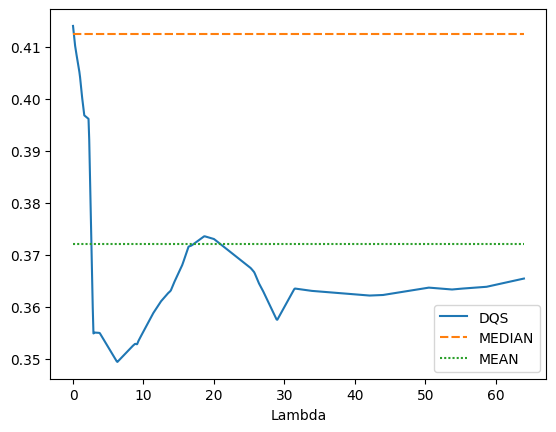

In [25]:
ax = sns.lineplot(ensemble)

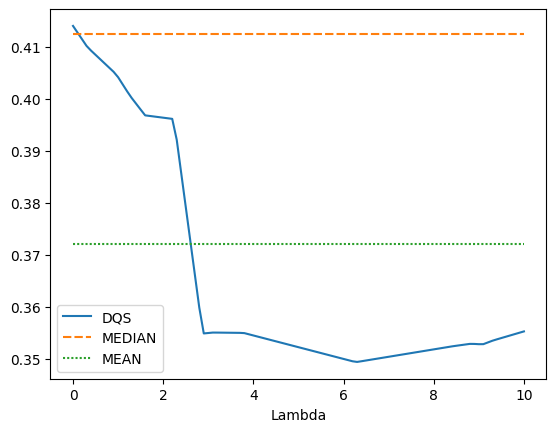

In [26]:
ax = sns.lineplot(ensemble.loc[:10.1])

In [ ]:
#ensemble.to_excel('DQSMAECurrentforLambda.xlsx')

## Optimal DQS Result

In [ ]:
series = dqs(removeOutlier(preds), 6.3)

In [ ]:
series.index = series.index.strftime('%Y%m')

In [ ]:
series.name = 'DQS'

In [ ]:
#series.to_excel('OptimalDQSCurrentTimeseries.xlsx')

# 1Q Ahead Quater

## Load Data

In [27]:
preds= pd.read_excel('pred_1qa.xlsx', index_col='TIME')
preds.index = pd.PeriodIndex(preds.index, freq='M')
preds = preds.asfreq('Q-DEC')

In [28]:
true = pd.read_excel('GDP_true.xlsx', index_col='TIME')
true.index = pd.PeriodIndex(true.index, freq='M')
true = true.asfreq('Q-DEC')
true = true.reindex(preds.index)
true = true['GDP(SA)']

## Ensemble

In [29]:
lambs = np.linspace(0, 64, 641)
ensemble = pd.DataFrame(data={'DQS': map(lambda lamb: calculateMAEforLambda(preds=removeOutlier(preds), lamb=lamb, y_true=true), lambs)}, index=pd.Index(lambs, name='Lambda'))

In [30]:
ensemble['MEDIAN'] = 0.53827
ensemble['MEAN'] = 0.55647

In [31]:
ensemble

,DQS,MEDIAN,MEAN
Lambda,,,
0.0,0.532820,0.53827,0.55647
0.1,0.531124,0.53827,0.55647
0.2,0.529046,0.53827,0.55647
0.3,0.527866,0.53827,0.55647
0.4,0.527563,0.53827,0.55647
...,...,...,...
63.6,0.592894,0.53827,0.55647
63.7,0.592973,0.53827,0.55647
63.8,0.593053,0.53827,0.55647


In [32]:
ensemble.iloc[ensemble['DQS'].argmin()]

DQS       0.492704
MEDIAN    0.538270
MEAN      0.556470
Name: 4.3, dtype: float64

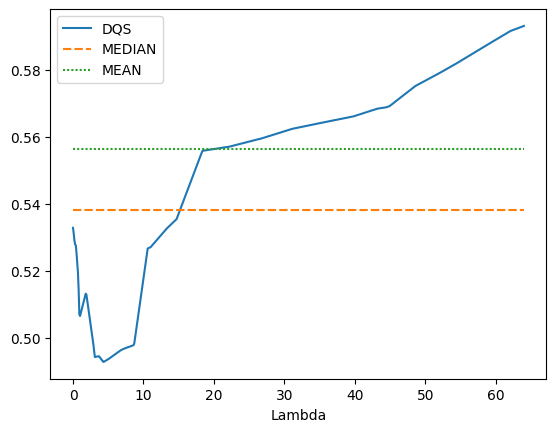

In [33]:
ax = sns.lineplot(ensemble)

In [34]:
#ensemble.to_excel('DQSMAE1QAheadforLambda.xlsx')

## Optimal DQS Result

In [35]:
series = dqs(removeOutlier(preds), 4.3)

In [36]:
series.index = series.index.strftime('%Y%m')

In [37]:
series.name = 'DQS'

In [38]:
#series.to_excel('OptimalDQS1QAheadTimeseries.xlsx')